In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import files
import pickle
uploaded = files.upload()

Saving Housing.csv to Housing (1).csv


In [2]:
df = pd.read_csv("Housing.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [3]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


- Price Analysis

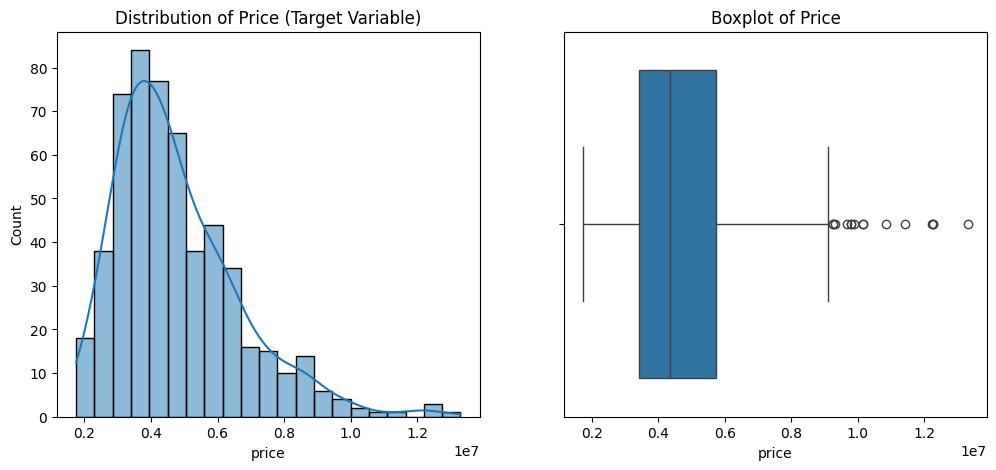

In [4]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['price'], kde=True)
plt.title('Distribution of Price (Target Variable)')
plt.subplot(1, 2, 2)
sns.boxplot(x=df['price'])
plt.title('Boxplot of Price')
plt.show()

# Correlation analysis

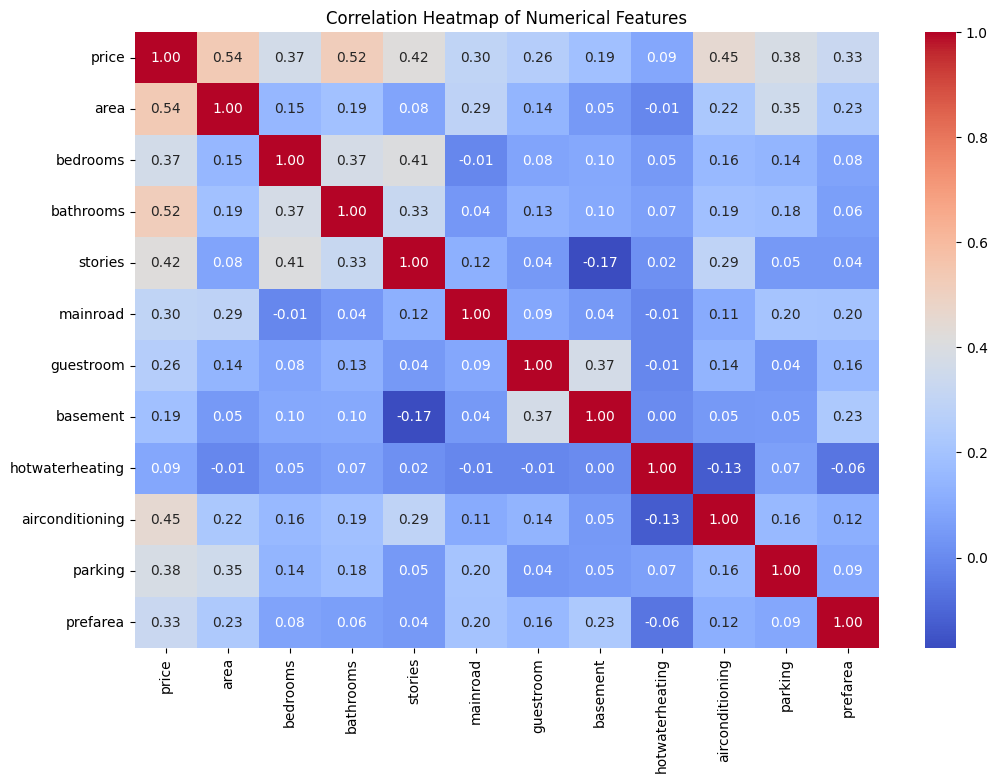

In [5]:
df_plot = df.copy()
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
df_plot[binary_cols] = df_plot[binary_cols].apply(lambda x: x.map({'yes': 1, 'no': 0}))

plt.figure(figsize=(12, 8))
sns.heatmap(df_plot.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Feature-vs-Price  and furnishingstatus Analysis

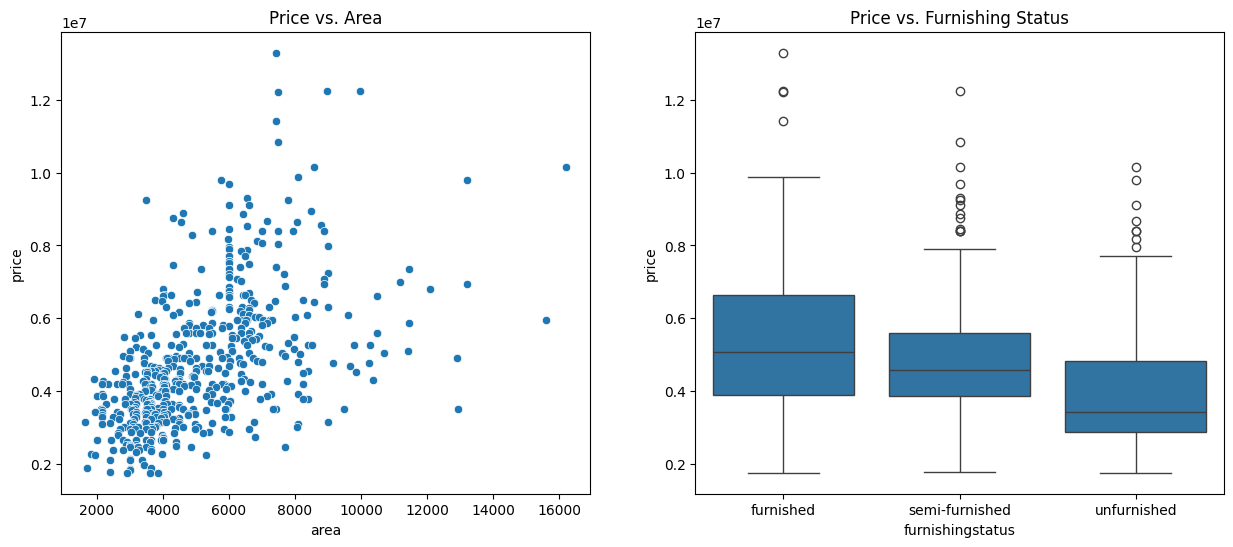

In [6]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='area', y='price', data=df)
plt.title('Price vs. Area')

plt.subplot(1, 2, 2)
sns.boxplot(x='furnishingstatus', y='price', data=df)
plt.title('Price vs. Furnishing Status')
plt.show()

# extracting info about columns

In [7]:
column_info = {}

for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):

        if df[col].nunique() < 10:
            column_info[col] = sorted(df[col].unique().tolist())
        else:
            column_info[col] = "numerical"
    else:
        column_info[col] = sorted(df[col].unique().tolist())
json_output = json.dumps(column_info, indent=4)
json_file_name = 'Housing_column_info.json'
with open(json_file_name, 'w') as f:
    f.write(json_output)

# Preprocessing data

- processing binary values columns

In [8]:
df[binary_cols] = df[binary_cols].apply(lambda x: x.map({'yes': 1, 'no': 0}))
df.head(2)[binary_cols]

,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea
0,1,0,0,0,1,1
1,1,0,0,0,1,0


- hot encoding categorical columns

In [9]:
df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True, dtype=int)
df.head(2)[['furnishingstatus_semi-furnished','furnishingstatus_unfurnished']]

,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,0,0
1,0,0


- splitting data set

In [10]:
y = df['price']
X = df.drop('price',axis=1)

X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape:{X_train.shape}")
print(f"X_test shape:{X_test.shape}")

X_train shape:(436, 13)
X_test shape:(109, 13)


- scaling numerical columns

In [11]:
numerical_cols_to_scale =['area','bedrooms','bathrooms','stories','parking']
scaler = StandardScaler()
X_train[numerical_cols_to_scale] =scaler.fit_transform(X_train[numerical_cols_to_scale])
X_test[numerical_cols_to_scale] =scaler.transform(X_test[numerical_cols_to_scale])

# Fom scratch Model

- regression model

In [12]:
class MyRidgeRegression:

    def __init__(self, learning_rate=0.01, n_iterations=1000, lambda_val=0.1):
        self.learning_rate=learning_rate
        self.n_iterations=n_iterations
        self.lambda_val=lambda_val
        self.weights =None
        self.bias=None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        cost_history = []
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            y_pred = np.dot(X, self.weights) + self.bias

            mse = (1 / n_samples) * np.sum((y_pred - y) ** 2)
            l2_penalty = (self.lambda_val / n_samples) * np.sum(np.square(self.weights))
            cost = mse + l2_penalty
            cost_history.append(cost)
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)
            dw_reg = (self.lambda_val / n_samples) * (2 * self.weights)
            dw += dw_reg
            self.weights-= self.learning_rate * dw
            self.bias -=self.learning_rate * db

        return cost_history

    def predict(self, X):
        return np.dot(X,self.weights)+self.bias


def mean_squared_error(y_true, y_pred):
    return np.mean((y_true-y_pred)** 2)

def r2_score(y_true, y_pred):
    tss = np.sum((y_true-np.mean(y_true))**2)
    rss = np.sum((y_true-y_pred)**2)
    r2 =1-(rss/tss)
    return r2

- main

In [13]:
X_train_np = X_train.values
y_train_np = y_train.values
X_test_np = X_test.values
y_test_np = y_test.values

ridge_model = MyRidgeRegression(
    learning_rate=0.01,
    n_iterations=1000,
    lambda_val=0.1
)

cost_history = ridge_model.fit(X_train_np, y_train_np)

- evolution des erreur au fur des epochs


--- Plotting Training Cost Evolution ---


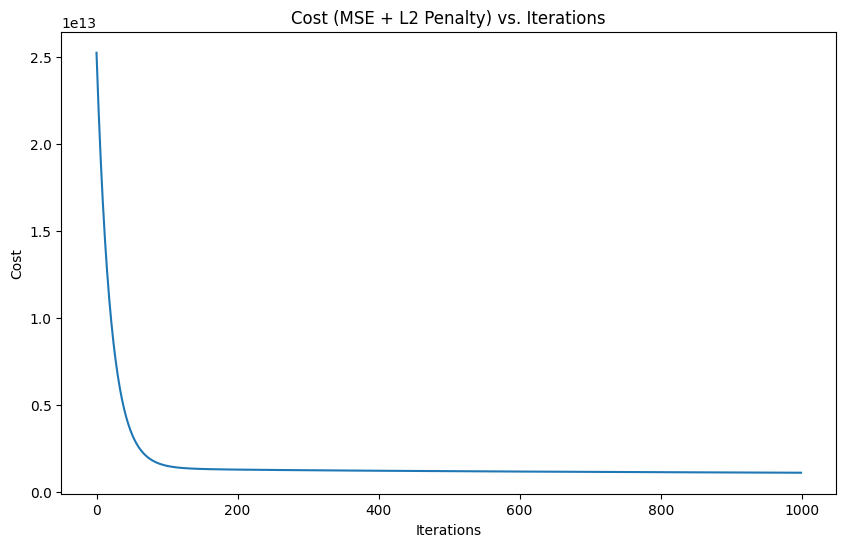

In [14]:
print("\n--- Plotting Training Cost Evolution ---")
plt.figure(figsize=(10, 6))
plt.plot(range(ridge_model.n_iterations), cost_history)
plt.title('Cost (MSE + L2 Penalty) vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

- evaluation du model en utilisant les donnees de test

In [15]:
y_pred_train = ridge_model.predict(X_train_np)
mse_train = mean_squared_error(y_train_np, y_pred_train)
r2_train = r2_score(y_train_np, y_pred_train)
print("\n--- Train Set ---")
print(f"Mean Squared Error (MSE): {mse_train:.2f}")
print(f"R-squared (R2): {r2_train:.4f}")

y_pred_test = ridge_model.predict(X_test_np)
mse_test = mean_squared_error(y_test_np, y_pred_test)
r2_test = r2_score(y_test_np, y_pred_test)
print("\n--- Test Set ---")
print(f"Mean Squared Error (MSE): {mse_test:.2f}")
print(f"R-squared (R2): {r2_test:.4f}")


--- Train Set ---
Mean Squared Error (MSE): 1123607320037.53
R-squared (R2): 0.6356

--- Test Set ---
Mean Squared Error (MSE): 1864186146793.82
R-squared (R2): 0.6312


- Plotting Train vs. Test Comparison

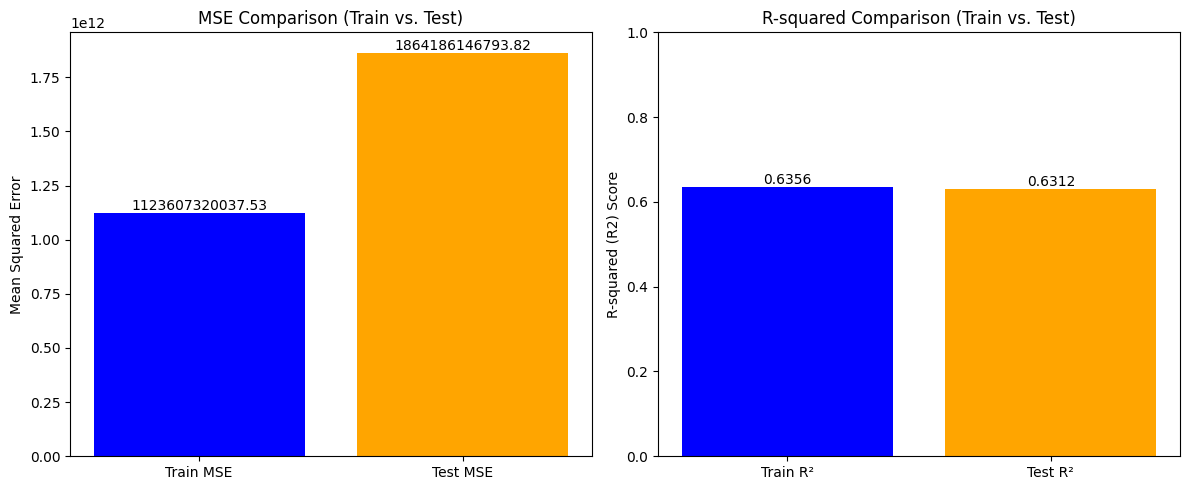

In [16]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
metrics_mse = ['Train MSE', 'Test MSE']
values_mse = [mse_train, mse_test]
bars = plt.bar(metrics_mse, values_mse, color=['blue', 'orange'])
plt.title('MSE Comparison (Train vs. Test)')
plt.ylabel('Mean Squared Error')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center')

plt.subplot(1, 2, 2)
metrics_r2 = ['Train R²', 'Test R²']
values_r2 = [r2_train, r2_test]
bars = plt.bar(metrics_r2, values_r2, color=['blue', 'orange'])
plt.title('R-squared Comparison (Train vs. Test)')
plt.ylabel('R-squared (R2) Score')
plt.ylim(0, 1)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center')
plt.tight_layout()
plt.show()


In [17]:
model_filename = 'ridge_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(ridge_model, file)

scaler_filename = 'scaler.pkl'
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)